In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

for symbol in NASDAQ100:
# for symbol in ['NDX']:
#     if symbol == 'AMZN':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 业务设置

start_date = '2008-06-02'
# start_date = '2017-01-03'
end_date = '2018-05-01'


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
    stock_df['pct_change'] = stock_df.close.pct_change(1)
    stock_df['open_pct_change'] = stock_df.open.pct_change(1)
    
    # Turtle指标
    stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
    stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
    stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
    stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
    stock_df['ATR_20'] = stock_df['TR'].rolling(20).mean()
    stock_df['N'] = (0.01 * 10000) / (stock_df['ATR_20'])
    
    # 减少数据
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 53.6 s


In [5]:
# stock_df_dict.keys()
# stock_df_dict['ATVI']

In [6]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 1e+03 µs


In [26]:
%%time

### Turtle
TURTLE_POS = 50
TURTLE_BUY_N = 60
TURTLE_SELL_N = 20

is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY
hold = []
order_df = pd.DataFrame(columns=['buy_date', 'symbol', 'buy_count', 'buy_price', 'sell_date', 'sell_price', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df.index:
        order = order_df.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        is_sell = (stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today])
#         is_sell = False
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
#             print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order['symbol'], order['buy_count'], stock_df_dict[order[1]].loc[today, 'open'], CASH, PROPERTY))
            order_df.loc[idx, 'sell_date'] = today
            order_df.loc[idx, 'sell_price'] = stock_df_dict[order[1]].loc[today, 'open']
            order_df.loc[idx, 'profit'] = (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < TURTLE_BUY_N:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < START_MONEY / TURTLE_POS:
                continue
            buy = int(START_MONEY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
#             print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            
    
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


189706.2225
0
283419.4625
[]
NDX 2028.33 6592.927 3.25042128253
Wall time: 21min 9s


In [27]:
'ALL'
'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** 0.1

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
calc_df

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

'ALL'

('len(order_df)', 4918)

('sum_profit', 183684.06530000025)

('sum_tax', 0)

('win rate', 0.42451665981077746)

('REWARD', 1.1098990871143863)

,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property,profit_pct
0,2008-08-12,ADBE,43,45.9100,2008-09-03,42.92,-128.57,98025.8700,100000,-0.0651274
1,2008-08-12,ALXN,84,23.7500,2008-08-27,21.73,-169.68,96030.8700,100000,-0.0850526
2,2008-08-12,AMZN,22,87.3200,2008-09-11,75.27,-265.1,94109.8300,100000,-0.137998
3,2008-08-12,AMGN,31,63.7900,2008-09-05,60.49,-102.3,92132.3400,100000,-0.0517322
4,2008-08-12,ADP,50,39.6356,2008-09-18,37.8775,-87.905,90150.5600,100000,-0.0443566
5,2008-08-12,CTAS,65,30.7000,2008-09-22,29.63,-69.55,88155.0600,100000,-0.0348534
6,2008-08-12,ESRX,54,36.6000,2008-09-10,35.74,-46.44,86178.6600,100000,-0.0234973
7,2008-08-12,FAST,77,25.7000,2008-09-26,25.225,-36.575,84199.7600,100000,-0.0184825
8,2008-08-12,HSIC,66,29.8850,2008-09-05,28.64,-82.17,82227.3500,100000,-0.0416597
9,2008-08-12,IDXX,71,27.9850,2008-09-15,27.25,-52.185,80240.4150,100000,-0.0262641


In [17]:
%%time

### Turtle + BT
TURTLE_POS = 20
TURTLE_BUY_N = 60
TURTLE_SELL_N = 60

tax = 0.002
is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY
hold = []
order_df_TB = pd.DataFrame(
    columns=['buy_date', 'strategy', 'symbol', 'buy_count', 'buy_price', 'expect', 'sell_date', 'sell_price', 'profit', 'tax', 'cash', 'property']
)
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df_TB.index:
        order = order_df_TB.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        if order['strategy'] == 'TURTLE':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today]
        elif order['strategy'] == 'BT':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] > order['expect']
            is_sell = is_sell or stock_df_dict[order['symbol']].loc[today, 'open'] / order['buy_price'] < 0.8
            is_sell = is_sell or today - order['buy_date'] > 30
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count'] - 6.95
#             print('%s 售出 %s SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order['strategy'], order['symbol'], order['buy_count'], stock_df_dict[order['symbol']].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB.loc[idx, 'sell_date'] = today
            order_df_TB.loc[idx, 'sell_price'] = stock_df_dict[order['symbol']].loc[today, 'open']
            order_df_TB.loc[idx, 'profit'] = (order_df_TB.loc[idx, 'sell_price'] - order_df_TB.loc[idx, 'buy_price']) * order_df_TB.loc[idx, 'buy_count']
            order_df_TB.loc[idx, 'tax'] = order_df_TB.loc[idx, 'tax'] + 6.95
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < TURTLE_BUY_N:
            continue
        
        is_buy = False
        
        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
            if is_buy:
                strategy = 'TURTLE'

        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open_pct_change'] < -0.05)
            if is_buy:
                strategy = 'BT'
        
        if is_buy:
            if CASH < START_MONEY / TURTLE_POS:
                continue
            buy = int(START_MONEY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy + 6.95
#             print('%s 进场 %s BUY %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, strategy, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB = order_df_TB.append(
                {
                    'buy_date': today,
                    'strategy': strategy,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'cash': CASH,
                    'profit': 0,
                    'tax': 6.95,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            
    show_df.loc[today, 'CASH_T+B'] = CASH
    PROPERTY = CASH + \
        sum([stock_df_dict[order_df_TB.loc[idx, 'symbol']].loc[today, 'open'] * order_df_TB.loc[idx, 'buy_count'] for idx in order_df_TB.loc[order_df_TB['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_T+B'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


1979.3266
0
1551553.9066
[]
NDX 2028.33 6592.927 3.25042128253
Wall time: 6min 46s


In [18]:
turtle_df = order_df_TB.loc[order_df_TB['strategy']=='TURTLE']
bt_df = order_df_TB.loc[order_df_TB['strategy']=='BT']

'ALL'
'len(order_df_TB)', len(order_df_TB)
sum_profit = sum(list(order_df_TB['profit']))
'sum_profit', sum_profit
sum_tax = sum(list(order_df_TB['tax']))
'sum_tax', sum_tax
'win rate', len(order_df_TB[order_df_TB.profit > 0]) / len(order_df_TB[order_df_TB.profit != 0])
'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** 0.1

'----------------------------'

'TURTLE'
'len(turtle_df)', len(turtle_df)
'sum_profit turtle', sum(list(turtle_df['profit']))
'win rate', len(turtle_df[turtle_df.profit > 0]) / len(turtle_df[turtle_df.profit != 0])

'----------------------------'

'BT'
'len(bt_df)', len(bt_df)
'sum_profit bt', sum(list(bt_df['profit']))
'win rate', len(bt_df[bt_df.profit > 0]) / len(bt_df[bt_df.profit != 0])


calc_df = order_df_TB.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
calc_df

# csv_file = 'E:/Dev/result/TB_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

'ALL'

('len(order_df_TB)', 834)

('sum_profit', 1203884.6658000008)

('sum_tax', 11140.849999999895)

('win rate', 0.6280884265279584)

('REWARD', 1.2916690304381053)

'----------------------------'

'TURTLE'

('len(turtle_df)', 499)

('sum_profit turtle', 912877.4356000002)

('win rate', 0.5444191343963554)

'----------------------------'

'BT'

('len(bt_df)', 335)

('sum_profit bt', 291007.23019999993)

('win rate', 0.7393939393939394)

,buy_date,strategy,symbol,buy_count,buy_price,expect,sell_date,sell_price,profit,tax,cash,property,profit_pct
0,2008-07-31,BT,XRAY,507,39.4300,41.5900,2008-08-15,41.74,1171.17,13.90,80002.0400,100000,0.0585848
1,2008-07-31,BT,HOLX,1045,19.1300,23.4100,2008-09-02,21.56,2539.35,13.90,60004.2400,100000,0.127026
2,2008-07-31,BT,ULTA,1902,10.5100,11.1100,2008-08-12,11.51,1902,13.90,40007.2700,100000,0.0951475
3,2008-08-01,BT,BIIB,413,48.3718,67.5014,2008-09-02,48.5871,88.9189,13.90,20022.7666,99979.2,0.00445094
4,2008-08-01,BT,ULTA,2114,9.4600,10.5100,2008-08-11,10.98,3213.28,13.90,17.3766,99979.2,0.160677
5,2008-08-12,TURTLE,ADBE,435,45.9100,45.1500,2008-09-18,37.66,-3588.75,13.90,25129.4166,105796,-0.179699
6,2008-08-12,TURTLE,ALXN,842,23.7500,23.1375,2008-10-10,17.63,-5153.04,13.90,5124.9666,105796,-0.257684
7,2008-08-15,TURTLE,AMZN,226,88.2800,85.7100,2008-09-30,65.84,-5071.44,13.90,6321.9666,107102,-0.254191
8,2008-09-02,TURTLE,ALGN,1517,13.1800,13.0000,2008-10-06,9.01,-6325.89,13.90,28903.7289,105030,-0.316388
9,2008-09-02,TURTLE,CTAS,633,31.5900,31.2600,2008-10-08,24.8,-4298.07,13.90,8900.3089,105030,-0.214941


In [11]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)


In [12]:
# pd.set_option('display.max_rows', 1000)
# record_df
# record_df.loc[record_df['ops']=='SELL'].sort_values(by=['profit'])

In [13]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = turtle_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 800)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

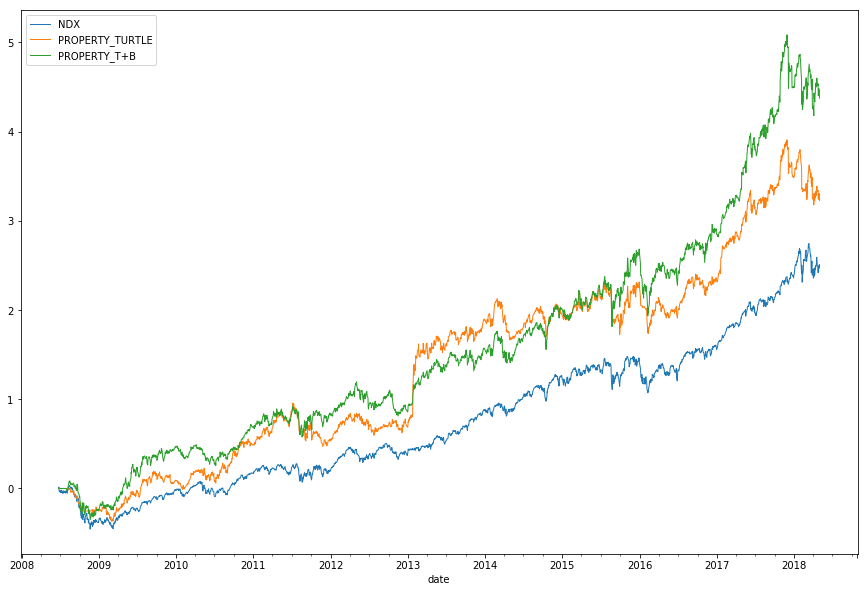

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_TURTLE'] = (df['PROPERTY_TURTLE'] - df.iloc[0]['PROPERTY_TURTLE']) / df.iloc[0]['PROPERTY_TURTLE']
df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.iloc[0]['PROPERTY_T+B']) / df.iloc[0]['PROPERTY_T+B']

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_TURTLE', secondary_y=False, label='PROPERTY_TURTLE', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T+B', secondary_y=False, label='PROPERTY_T+B', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()

# df = df.loc[:, ['close', 'PROPERTY_TURTLE', 'PROPERTY_T+B']]
# df
# display_charts(df, kind='line', figsize=(900, 600), logy=False)